# <center> Лабораторная работа
## <center> Случайный лес в задаче кредитного скоринга

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	     ----Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                         ---- Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	----Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio ----	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	----Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate ----Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse----	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; ; тип -	integer
* NumberOfDependents ----Число человек в семье кредитозаёмщика; тип -	integer

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [4]:
## Считываем данные
data = pd.read_csv('https://github.com/innagorda/lab-Decision-trees/raw/master/credit_scoring_sample.csv', sep =';') 
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [5]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

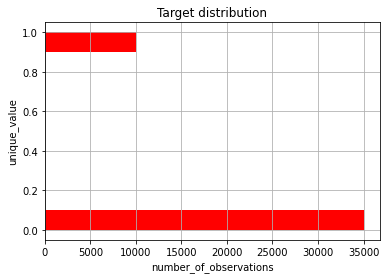

In [6]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [7]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names


['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [8]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table =delete_nan(data)


In [9]:
## Разделяем таргет и признаки 
X =table[independent_columns_names]
y = table['SeriousDlqin2yrs']


# Бутстрэп

В следующей части кода рассчитывается интервальная оценка среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". 

In [10]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по клиентам
bum_age = data[data['SeriousDlqin2yrs'] == 1]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
bum_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(bum_age, 1000)]

#  выводим интервальную оценку среднего
print("Bums' ages:  mean interval",  stat_intervals(bum_mean_scores, 0.1))

Bums' ages:  mean interval [45.71379414 46.12700479]


Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# Случайный лес

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

Используем для подбора параметров модели случайного леса **GridSearchCV** с параметрами:

*   **estimator**: **estimator object** (проинициализированный ранее случайнный лес)
*   **cv**: **int, cross-validation generator or an iterable, default=None** Определяет стратегию разделения перекрестной проверки. (проинициализированная ранее стрэтифайд k-fold валидация)
*   **param_grid: dict or list of dictionaries**. Словарь с именами параметров в качестве ключей и списками настроек параметров, которые можно попробовать в качестве значений. (параметры из определенного выше набора)
*   **n_jobs: int, default=None** Количество потоков для параллельного выполнения. Параметр -1 означает, что нужно использовать максимальное возможное количество потоков.
*   **scoring: str, callable, list/tuple or dict, default=None** Одна строковая переменная или вызываемая функция для оценки прогнозов в наборе тестов. В нашем случае это 'roc_auc'

Обучаем с помощью **fit** на наборе таргетов и признаков и отображаем лучшие результаты. Обучение может занимать до 10 минут








In [14]:
%%time
### Ваш код должен быть здесь ###
print(gsc.best_score_, gsc.best_params_)

0.8357174834725474 {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 9}
CPU times: user 9.65 s, sys: 261 ms, total: 9.91 s
Wall time: 8min 3s


**Определите, какой признак имеет самое слабое влияние**

Все признаки были ранее сохранены в independent_columns_names. Влияние признаков классификатора можно узнать с помощью свойства **feature_importances_**

In [ ]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced', ### параметры, подобранные с помощью GridSearchCV ###)
### Обучаем с помощью **fit** на наборе таргетов и признаков ###
### Ваш код должен быть здесь ###

# Бэггинг

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Следующая задача - обучение бэггинг классификатора (random_state=42).** В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Так же не забудьте передать параметр валидации cv и `random_state=1`. Какая лучшая точность получилась?

In [ ]:
%%time
### Ваш код должен быть здесь ###
print(rsb.best_score_, rsb.best_params_)

**Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?**

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации

<center>
##Открытый курс по машинному обучению
</center>
Авторы оригинального материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, аналитик Вымпелком Саян Омаров